## 1. Import Libraries and Set Device

In [1]:
# --- General Libraries ---
import os
import warnings

# --- Data Handling ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Image Handling and Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# --- PyTorch and Deep Learning ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# --- Utilities ---
from tqdm import tqdm
import joblib

# --- Warning Suppression ---
warnings.filterwarnings('ignore')


In [2]:
# Set the device for PyTorch computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print(f"Using {device} device")
print(f"CUDA Available: {torch.cuda.is_available()}")

# If CUDA is available, print additional details
if torch.cuda.is_available():
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using cuda device
CUDA Available: True
Number of CUDA Devices: 1
Current CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4060 Ti


## 2. Data Loading and Preprocessing

In [3]:
root_dir = "lung_colon_image_set"
image_paths = []
multi_labels = []

label_mapping = {
    'lung_n': 0, 'lung_aca': 1, 'lung_scc': 2,
    'colon_n': 3, 'colon_aca': 4
}

class_names = list(label_mapping.keys())

# Yeni modelde artık sadece multiclass etiketlemeyi kullanıyoruz
for subfolder in ['lung_image_sets/lung_n', 'lung_image_sets/lung_aca', 'lung_image_sets/lung_scc',
                  'colon_image_sets/colon_n', 'colon_image_sets/colon_aca']:
    class_dir = os.path.join(root_dir, subfolder)
    class_name = subfolder.split('/')[-1]

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        multi_labels.append(label_mapping[class_name])

print(f"Total Image: {len(image_paths)}")


Total Image: 25000


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.85, 1.15))], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), 
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Regular transform for test/validation data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
class FeatureDataset(Dataset):
    def __init__(self, image_paths, multi_labels, transform=None):
        self.image_paths = image_paths
        self.multi_labels = multi_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.multi_labels[idx]


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, multi_labels, test_size=0.3, random_state=42, stratify=multi_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create datasets with respective transformations
train_dataset = FeatureDataset(X_train, y_train, transform=train_transform)
val_dataset = FeatureDataset(X_val, y_val, transform=test_transform)
test_dataset = FeatureDataset(X_test, y_test, transform=test_transform)

# Create data loaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 3. EfficientNetB3 + Random Forrest

In [7]:
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
model.classifier = torch.nn.Identity() 
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [8]:
def extract_features(dataloader, model, device='cuda'):
    all_features = []
    all_labels = []

    model.eval()  # Modeli değerlendirme moduna al

    with torch.no_grad():  # Hesaplamaları kaydetme
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Görüntüleri CUDA'ya taşı
            labels = labels.to(device)  # Etiketleri CUDA'ya taşı

            features = model(inputs)  # Modelden özellikleri çıkar

            all_features.append(features.cpu().numpy())  # Özellikleri listeye ekle
            all_labels.extend(labels.cpu().numpy())  # Etiketleri listeye ekle

    return np.concatenate(all_features), np.array(all_labels)  # Özellikleri ve etiketleri döndür


In [9]:
X_train_feat, y_train = extract_features(train_loader, model)
X_test_feat, y_test = extract_features(test_loader, model)

In [10]:
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi.fit(X_train_feat, y_train)

RandomForestClassifier(random_state=42)

In [33]:
# Multiclass prediction
y_multi_pred = rf_multi.predict(X_test_feat)

# Print classification report
print("🔎 Multiclass Classification Report:")
print(classification_report(y_test, y_multi_pred, target_names=[
    "Lung Benign", "Lung ACA", "Lung SCC", "Colon Benign", "Colon ACA"
]))

🔎 Multiclass Classification Report:
              precision    recall  f1-score   support

 Lung Benign       0.87      1.00      0.93       750
    Lung ACA       0.92      0.64      0.75       750
    Lung SCC       0.91      0.91      0.91       750
Colon Benign       0.95      0.98      0.97       750
   Colon ACA       0.87      0.97      0.91       750

    accuracy                           0.90      3750
   macro avg       0.90      0.90      0.90      3750
weighted avg       0.90      0.90      0.90      3750



🔍 Confusion Matrix:


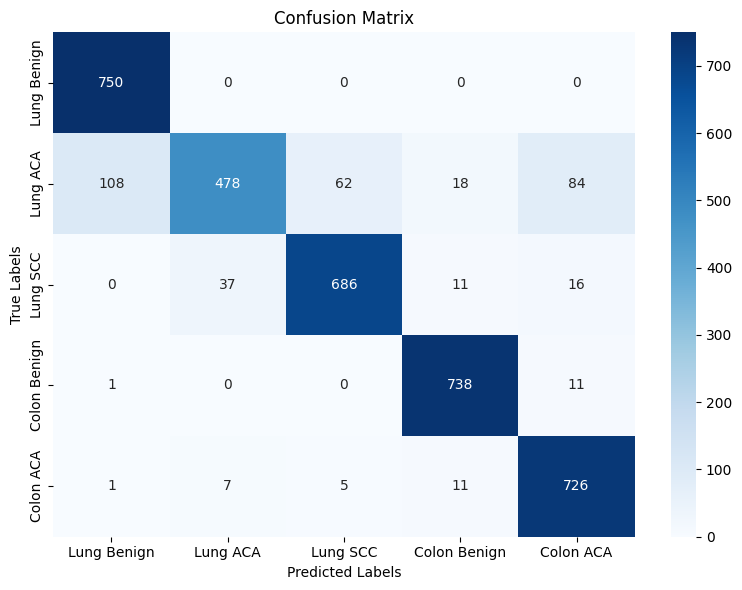

In [36]:
print("🔍 Confusion Matrix:")
cm = confusion_matrix(y_test, y_multi_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Lung Benign", "Lung ACA", "Lung SCC", "Colon Benign", "Colon ACA"],
            yticklabels=["Lung Benign", "Lung ACA", "Lung SCC", "Colon Benign", "Colon ACA"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Save the trained RandomForest model
save_path_rf = "random_forest_model.pth"
joblib.dump(rf_multi, save_path_rf)
print(f"RandomForest model saved to {save_path_rf}")

RandomForest model saved to random_forest_model.pth


## 4. Resnet34 Classification Fine Tuning

In [19]:
# ResNet34 modelini yükle
resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# Son katmanı yeniden yapılandır
num_ftrs = resnet34.fc.in_features  # ResNet34'ün son katmanının girdi özellikleri
resnet34.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))  # Burada class_names, sınıf sayısına eşit olmalı
)

resnet34 = resnet34.to(device)

In [20]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training One Epoch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights

        running_loss += loss.item()  # Sum the loss for average calculation
        _, predicted = torch.max(outputs, 1)  # Get the class predictions
        total += labels.size(0)  # Number of examples
        correct += (predicted == labels).sum().item()  # Correct predictions count

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

In [21]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()  # Sum the loss for average calculation
            _, predicted = torch.max(outputs, 1)  # Get the class predictions
            total_val += labels.size(0)  # Number of examples
            correct_val += (predicted == labels).sum().item()  # Correct predictions count

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return avg_val_loss, val_accuracy

In [ ]:
def train(model, train_loader, val_loader, epochs=10, patience=3, device='cuda', save_path="best_resnet_model.pth"):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_loss = float('inf')
    patience_counter = 0

    # Lists to store losses and accuracies for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase (train for one epoch)
        avg_train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Append training metrics to lists for plotting
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase (validate for one epoch)
        avg_val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Append validation metrics to lists for plotting
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0  # Reset counter if validation loss improves

            # Save the best model
            print("Validation loss improved, saving the model...")
            torch.save(model.state_dict(), save_path)  # Save the best model

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [23]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs=50, patience=3, device='cuda')

Training One Epoch: 100%|██████████| 547/547 [04:06<00:00,  2.22it/s]


Epoch 1/50, Train Loss: 2.4281, Train Accuracy: 91.73%
Epoch 1/50, Validation Loss: 1.3862, Validation Accuracy: 95.89%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 2/50, Train Loss: 1.5498, Train Accuracy: 93.75%
Epoch 2/50, Validation Loss: 0.8427, Validation Accuracy: 95.36%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:04<00:00,  2.24it/s]


Epoch 3/50, Train Loss: 0.9575, Train Accuracy: 96.01%
Epoch 3/50, Validation Loss: 0.3617, Validation Accuracy: 98.27%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:04<00:00,  2.24it/s]


Epoch 4/50, Train Loss: 0.6079, Train Accuracy: 96.86%
Epoch 4/50, Validation Loss: 0.2099, Validation Accuracy: 98.83%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [05:29<00:00,  1.66it/s]


Epoch 5/50, Train Loss: 0.4045, Train Accuracy: 97.83%
Epoch 5/50, Validation Loss: 0.1527, Validation Accuracy: 99.41%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:25<00:00,  2.06it/s]


Epoch 6/50, Train Loss: 0.2779, Train Accuracy: 98.14%
Epoch 6/50, Validation Loss: 0.1107, Validation Accuracy: 98.64%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:36<00:00,  1.98it/s]


Epoch 7/50, Train Loss: 0.1943, Train Accuracy: 98.64%
Epoch 7/50, Validation Loss: 0.0562, Validation Accuracy: 99.87%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [05:16<00:00,  1.73it/s]


Epoch 8/50, Train Loss: 0.1515, Train Accuracy: 98.70%
Epoch 8/50, Validation Loss: 0.0317, Validation Accuracy: 99.81%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 9/50, Train Loss: 0.1289, Train Accuracy: 98.71%
Epoch 9/50, Validation Loss: 0.0271, Validation Accuracy: 99.89%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 10/50, Train Loss: 0.0979, Train Accuracy: 99.00%
Epoch 10/50, Validation Loss: 0.0272, Validation Accuracy: 99.79%


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 11/50, Train Loss: 0.0924, Train Accuracy: 98.83%
Epoch 11/50, Validation Loss: 0.0156, Validation Accuracy: 99.89%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 12/50, Train Loss: 0.0625, Train Accuracy: 99.25%
Epoch 12/50, Validation Loss: 0.0107, Validation Accuracy: 99.84%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:06<00:00,  2.22it/s]


Epoch 13/50, Train Loss: 0.0652, Train Accuracy: 98.97%
Epoch 13/50, Validation Loss: 0.0148, Validation Accuracy: 99.81%


Training One Epoch: 100%|██████████| 547/547 [04:07<00:00,  2.21it/s]


Epoch 14/50, Train Loss: 0.0415, Train Accuracy: 99.36%
Epoch 14/50, Validation Loss: 0.0086, Validation Accuracy: 99.92%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 15/50, Train Loss: 0.0354, Train Accuracy: 99.49%
Epoch 15/50, Validation Loss: 0.0050, Validation Accuracy: 99.97%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:09<00:00,  2.19it/s]


Epoch 16/50, Train Loss: 0.0464, Train Accuracy: 99.11%
Epoch 16/50, Validation Loss: 0.0145, Validation Accuracy: 99.73%


Training One Epoch: 100%|██████████| 547/547 [04:10<00:00,  2.19it/s]


Epoch 17/50, Train Loss: 0.0322, Train Accuracy: 99.44%
Epoch 17/50, Validation Loss: 0.0044, Validation Accuracy: 100.00%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:09<00:00,  2.19it/s]


Epoch 18/50, Train Loss: 0.0358, Train Accuracy: 99.25%
Epoch 18/50, Validation Loss: 0.0052, Validation Accuracy: 99.92%


Training One Epoch: 100%|██████████| 547/547 [04:09<00:00,  2.20it/s]


Epoch 19/50, Train Loss: 0.0283, Train Accuracy: 99.42%
Epoch 19/50, Validation Loss: 0.0037, Validation Accuracy: 99.95%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 20/50, Train Loss: 0.0313, Train Accuracy: 99.37%
Epoch 20/50, Validation Loss: 0.0030, Validation Accuracy: 99.95%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 21/50, Train Loss: 0.0243, Train Accuracy: 99.58%
Epoch 21/50, Validation Loss: 0.0028, Validation Accuracy: 100.00%
Validation loss improved, saving the model...


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 22/50, Train Loss: 0.0178, Train Accuracy: 99.59%
Epoch 22/50, Validation Loss: 0.0070, Validation Accuracy: 99.84%


Training One Epoch: 100%|██████████| 547/547 [04:07<00:00,  2.21it/s]


Epoch 23/50, Train Loss: 0.0201, Train Accuracy: 99.55%
Epoch 23/50, Validation Loss: 0.0099, Validation Accuracy: 99.79%


Training One Epoch: 100%|██████████| 547/547 [04:08<00:00,  2.20it/s]


Epoch 24/50, Train Loss: 0.0250, Train Accuracy: 99.40%
Epoch 24/50, Validation Loss: 0.0041, Validation Accuracy: 99.95%
Early stopping triggered.


In [24]:
def plot_train_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot the training and validation loss and accuracy for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


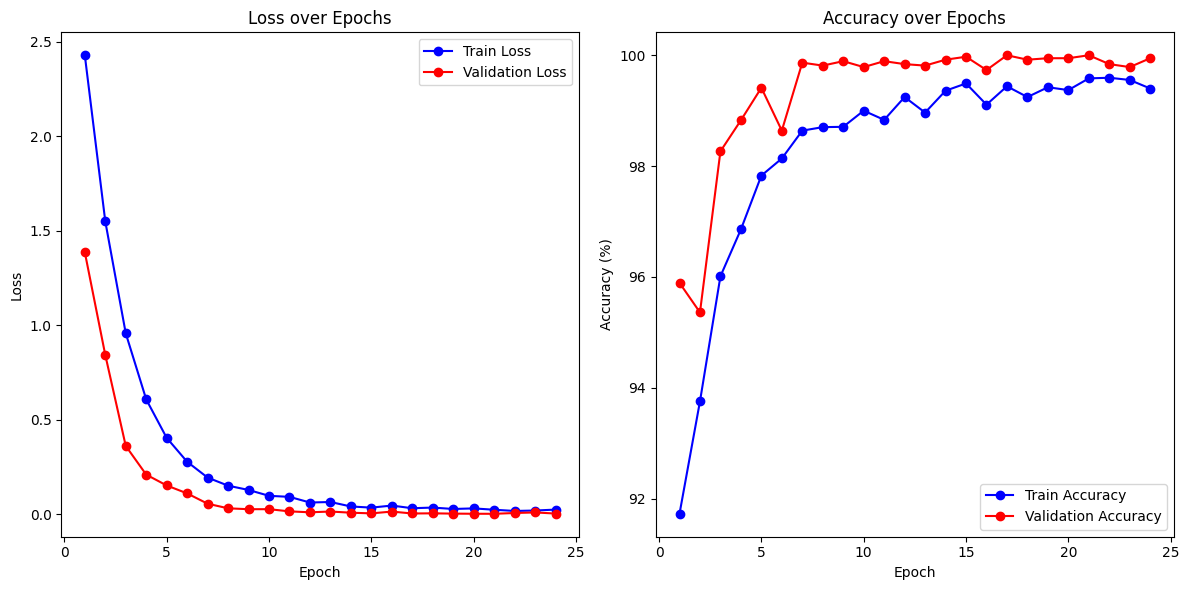

In [25]:
plot_train_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [26]:
def test_model(model, test_loader, device='cuda', class_names=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (correct / total) * 100

    print(f"\n🧪 Test Loss: {avg_test_loss:.4f}")
    print(f"✅ Test Accuracy: {test_accuracy:.2f}%")
    
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return avg_test_loss, test_accuracy


🧪 Test Loss: 0.0040
✅ Test Accuracy: 99.95%

📊 Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       750
    lung_aca       1.00      1.00      1.00       750
    lung_scc       1.00      1.00      1.00       750
     colon_n       1.00      1.00      1.00       750
   colon_aca       1.00      1.00      1.00       750

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750



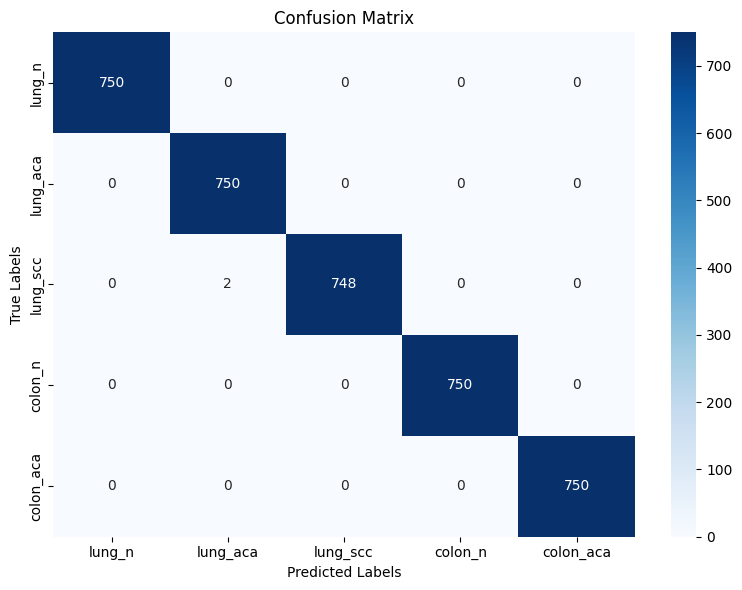

In [27]:
test_loss, test_accuracy = test_model(model, test_loader, device='cuda', class_names=class_names)

## 5. Ensemble Method (Soft Voting)

In [43]:
def ensemble_predict_weighted_voting(resnet_model, rf_model, test_loader, X_test_feat, class_names, device='cuda', resnet_weight=0.8, rf_weight=0.2):
    resnet_model.eval()
    all_ensemble_preds = []
    all_labels = []

    rf_probs_all = rf_model.predict_proba(X_test_feat)

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_probs = torch.softmax(resnet_outputs, dim=1).cpu().numpy()

            batch_size = images.size(0)
            rf_probs = rf_probs_all[i * batch_size: (i + 1) * batch_size]

            avg_probs = (resnet_probs * resnet_weight + rf_probs * rf_weight)
            ensemble_preds = np.argmax(avg_probs, axis=1)

            all_ensemble_preds.extend(ensemble_preds)
            all_labels.extend(labels.cpu().numpy())

    print("\nEnsemble Model Classification Report:")
    print(classification_report(all_labels, all_ensemble_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_ensemble_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return all_labels, all_ensemble_preds


Ensemble Model Classification Report:
              precision    recall  f1-score   support

      lung_n       0.94      0.98      0.96       750
    lung_aca       0.88      0.72      0.79       750
    lung_scc       0.88      0.94      0.91       750
     colon_n       0.97      0.97      0.97       750
   colon_aca       0.87      0.93      0.90       750

    accuracy                           0.91      3750
   macro avg       0.91      0.91      0.91      3750
weighted avg       0.91      0.91      0.91      3750



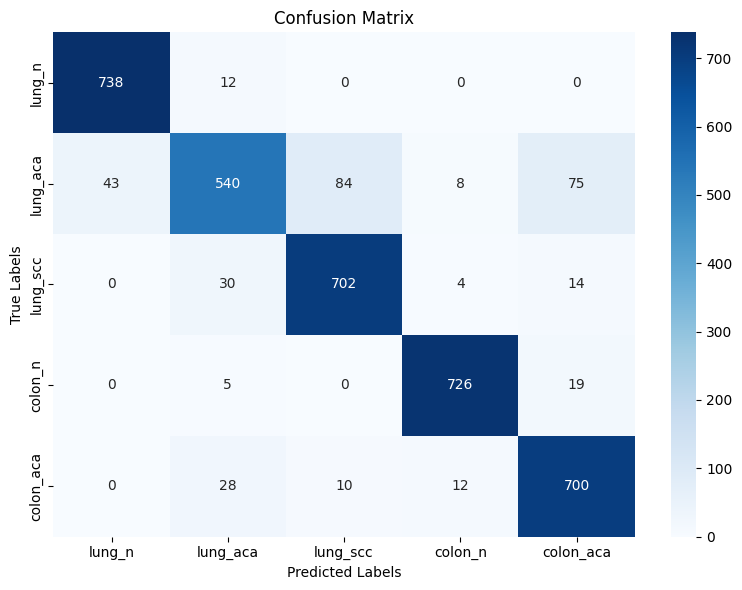

In [44]:
true_labels, predicted_labels = ensemble_predict_weighted_voting(
    resnet_model=resnet34,
    rf_model=rf_multi,
    test_loader=test_loader,
    X_test_feat=X_test_feat,
    class_names=class_names,
    device='cuda'
)


### 1. Durum Noktasındaki Eğitim Train

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])



#### 1.1. EFNet + Random Forest

🔎 Multiclass Classification Report:
              precision    recall  f1-score   support

 Lung Benign       0.87      1.00      0.93       750
    Lung ACA       0.92      0.64      0.75       750
    Lung SCC       0.91      0.91      0.91       750
Colon Benign       0.95      0.98      0.97       750
   Colon ACA       0.87      0.97      0.91       750

    accuracy                           0.90      3750
   macro avg       0.90      0.90      0.90      3750
weighted avg       0.90      0.90      0.90      3750

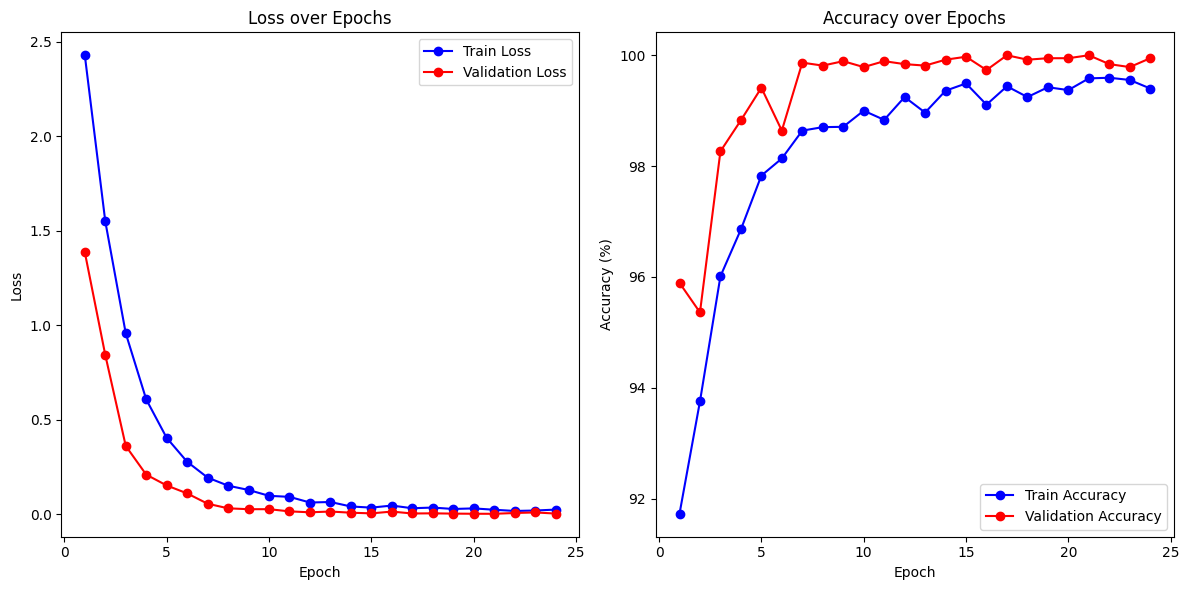

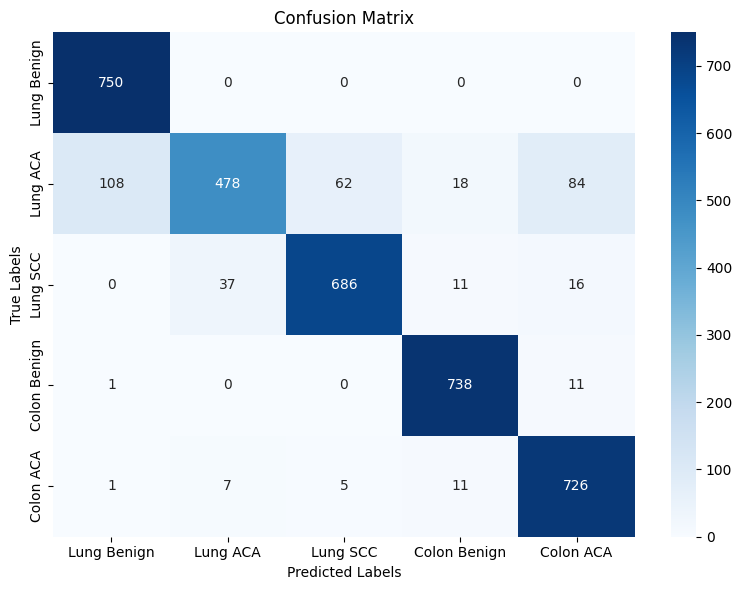

#### 1.2. ResNet Fine Tuning

🧪 Test Loss: 0.0040
✅ Test Accuracy: 99.95%

📊 Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       750
    lung_aca       1.00      1.00      1.00       750
    lung_scc       1.00      1.00      1.00       750
     colon_n       1.00      1.00      1.00       750
   colon_aca       1.00      1.00      1.00       750

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750

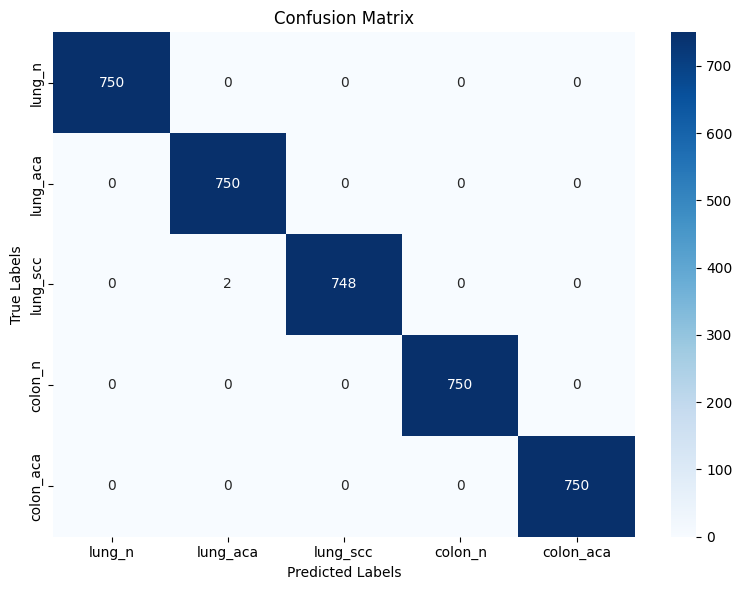

#### 1.3. Weighted Ensemble Result 0.8 Resnet 0.2 Random Forest


Ensemble Model Classification Report:
              precision    recall  f1-score   support

      lung_n       0.94      0.98      0.96       750
    lung_aca       0.88      0.72      0.79       750
    lung_scc       0.88      0.94      0.91       750
     colon_n       0.97      0.97      0.97       750
   colon_aca       0.87      0.93      0.90       750

    accuracy                           0.91      3750
   macro avg       0.91      0.91      0.91      3750
weighted avg       0.91      0.91      0.91      3750


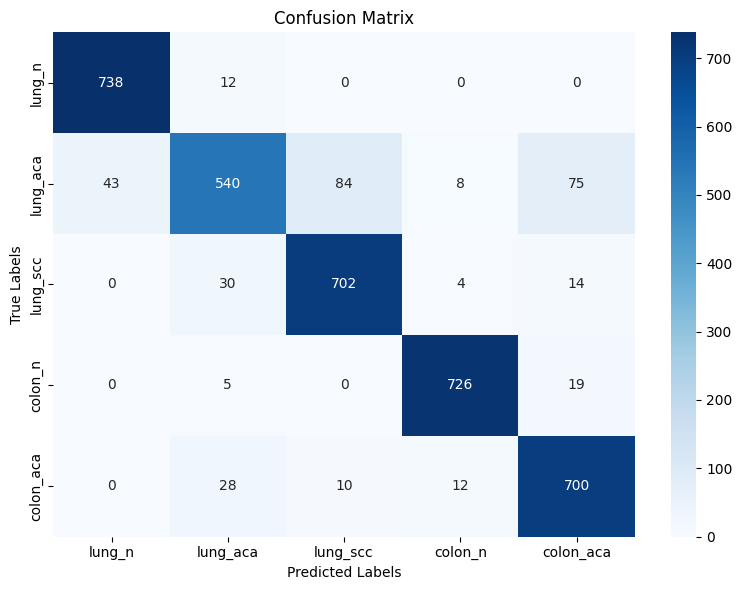